In [41]:
import numpy as np
import glob
from astropy.table import Table
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
import inspect
import matplotlib.pyplot as plt
from astropy.time import Time


In [42]:
snrcut = 3
source = 'MOSFiT'
fittype = 'SNII-NMF'
verbose = True


In [43]:
models = sorted(glob.glob(f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/*.fits'))
print(f"{len(models)} models found") 


384 models found


In [44]:
path_sedinfo = f'../model/PLAsTiCC/{fittype}/SIMSED.{fittype}/SED.INFO'
infotbl = tablize_sedinfo(path_sedinfo, models)


In [45]:
ii = 10
model = models[ii]
_mdtbl = Table.read(model)

indx = np.where(
    (_mdtbl['col1'] <= 30) &
    (_mdtbl['col2'] >= 2000) &
    (_mdtbl['col2'] <= 9000)
    # (_mdtbl['col2'] <= 11000)
    # (_mdtbl['col2'] <= 10000)
)

mdtbl = _mdtbl[indx]
phasearr = np.unique(mdtbl['col1'])
lamarr = np.unique(mdtbl['col2'])
number_of_unique_phase, number_of_unique_wavelength = len(phasearr), len(lamarr)
flux2darr = mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength)

print(f"Table length: {len(_mdtbl)} --> {len(mdtbl)}")

Table length: 45150 --> 17525


In [46]:
param_keys = infotbl.keys()[2:]
param_keys

['pc1', 'pc2', 'pc3']

In [47]:
interp = RegularGridInterpolator((phasearr, lamarr), flux2darr, method='linear')
# point = (
#     10,
#     lamarr
# )
# iflux = interp(point)

In [48]:
register_custom_filters_on_speclite('../util')

# %%
intype = 'kn'
indist = 40
inexptime = 180
# group = 'broad_ugriz'
group = input("""Choose the filterset (med25nm, broad_griz, broad_ugriz):""")
if group == 'med25nm':
	filterset_group = filterlist_med25nm
elif group == 'broad_griz':
	filterset_group = filterlist_griz
elif group == 'broad_ugriz':
	filterset_group = filterlist_ugriz
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group]
bands = speclite.filters.load_filters(*filterset)

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [49]:
if 'med' in bands.names[0]:
	#    Medium-band
	bandwidth = 250 # [AA]
	lammin = 3000
	lammax = 10000
else:
	#	Broad-band
	bandwidth = 1000 # [AA]
	lammin = 2000
	lammax = 12000

lamstep = bandwidth/10
# lamarr = np.arange(lammin, lammax+lamstep, lamstep)
# _lamarr = np.arange(lammin, lammax+lamstep, 10)

print(f"lam: {lammin:.3f} - {lammax:.3f} AA")
print(f"lamstep: {lamstep:g} AA")
print(f"n_lam: {len(lamarr)}")

lam: 3000.000 - 10000.000 AA
lamstep: 25 AA
n_lam: 701


- Function to fit

In [50]:
def func(x, z, t):
	factor = 262.5606
	#	Input
	point = (
		t,
		lamarr,
	)

	iflux = interp(point)*factor
	# iflux = interp(point)
	(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	# print(z, t)

	return spfnu

- Observation Table for Input

In [51]:
if group == 'med25nm':
	#	Medium-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
else:
	#	Broad-band
	path_input = f'../input/{intype}/{indist:0>3}Mpc/{inexptime:0>3}s/broad'
path_output = f'../fit_result/{intype}2{fittype}/{indist:0>3}Mpc/{inexptime:0>3}s/{group}'
if not os.path.exists(path_output):
	os.makedirs(path_output)
outfits = f"{path_output}/fit_result.fits"

# %%
intablelist = sorted(glob.glob(f"{path_input}/obs.*.fits"))
print(f"{len(intablelist)} input tables found")

3600 input tables found


In [52]:
# ii = 10
intable = intablelist[ii]
print(f"{os.path.basename(intable)} ({inexptime}s) --> {fittype}")
intbl = Table.read(intable)

# %%
indx_det = np.where(intbl['snr']>snrcut)
filterlist_det = list(intbl['filter'][indx_det])
filterlist_str = ",".join(filterlist_det)

# %%
filterset = [f"{group}-{filte}" for filte, _, group in filterset_group if filte in filterlist_det]
bands = speclite.filters.load_filters(*filterset)

# %%
# %%
ndet = len(filterset)
detection = np.any(intbl['snr'] > 5)
if verbose:
	print(f"number of detections: {ndet}")
	print(f"detection: {detection}")

# %%
xdata = intbl['fnuobs'].data[indx_det]
ydata = xdata
sigma = intbl['fnuerr'].data[indx_det]

obs.000010.fits (180s) --> SNII-NMF
number of detections: 18
detection: True


In [53]:
#	Initial Guess
p0 = (
	0.01,
	np.mean(phasearr)
)

#	Boundaries
bounds = (
	(1e-6, np.min(phasearr)),
	(1e0, np.max(phasearr)),
)

In [54]:
n_free_param = len(inspect.signature(func).parameters)-1

fit = False
popt, pcov = curve_fit(
	func,
	xdata=xdata,
	ydata=ydata,
	sigma=sigma,
	# p0=p0,
	absolute_sigma=True,
	check_finite=True,
	bounds=bounds,
	method='trf',
	max_nfev=1e4,
)
fit = True

0.5000005 8.25
0.5000005149011612 8.25
0.5000005 8.25000012293458
0.013579853394281305 -0.03362311552033326
0.16847841573221184 7.665872358684957
0.16847843063337303 7.665872358684957
0.16847841573221184 7.665872472915356
0.008293861079544135 3.667609705358281
0.06887571366309528 7.605629741251617
0.06887572856425647 7.605629741251617
0.06887571366309528 7.605629854584332
0.01595217632299705 5.622581431830866
0.036989137935520625 7.596963130517441
0.03698915283668182 7.596963130517441
0.036989137935520625 7.596963243721013
0.022919218048476277 6.557994851733163
0.02291923294963747 6.557994851733163
0.022919218048476277 6.557994949454901
0.024617710814289536 4.4360758358966255
0.02461772571545073 4.4360758358966255
0.024617710814289536 4.436075901999306
0.024814253623499302 1.4858065546687969
0.024814268524660496 1.4858065546687969
0.024814253623499302 1.4858065768090398
0.024556223956085893 0.6474573118065952
0.024556238857247087 0.6474573118065952
0.024556223956085893 0.64745732670775

12 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [15]:
#	Fitting result
r = ydata.data - func(xdata, *popt)
n_free_param = len(inspect.signature(func).parameters)-1
dof = ndet - n_free_param
chisq_i = (r / sigma) ** 2
chisq = np.sum(chisq_i)
chisqdof = chisq/dof
bic = chisq + n_free_param*np.log(ndet)
perr = np.sqrt(np.diag(pcov))

# %%
z = popt[0]
t = popt[1]
if verbose:
	print(f"z={z:.3}")
	print(f"t={t:.3}")

# %%
outpng = f"{path_output}/{os.path.basename(intable).replace('obs', 'fit').replace('fits', 'png')}"

z=0.0244
t=0.145


In [16]:
factor = 262.5606
#	Input
point = (
	t,
	lamarr,
)

iflux = interp(point)*factor
# iflux = interp(point)
(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0=0)
fnuarr = convert_flam2fnu(zspappflam, zsplam).to(u.uJy)

In [17]:
label = f"""n_det={ndet}, rchisq={chisqdof:.3}, bic={bic:.3}
z ={z:.3f}, t ={t:.3f}"""

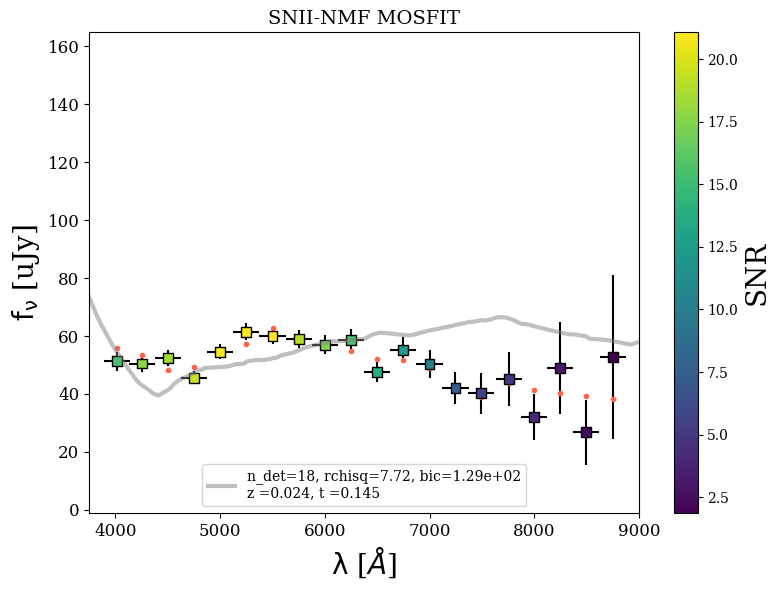

In [18]:
plt.close('all')
plt.figure(figsize=(8, 6))
#	Fitted spectrum
plt.plot(lamarr, fnuarr, c='grey', lw=3, alpha=0.5, label=label)
yl, yu = plt.ylim()
#	Input data
plt.scatter(intbl['lam'], intbl['fnuobs'], c=intbl['snr'], marker='s', s=50, ec='k')
if 'med' in group:
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidth/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)
elif 'broad' in group:
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidtharr_broad/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)

#	Colorbar
cbar = plt.colorbar()
cbar.set_label("SNR")

#	Input data w/o scatter
plt.plot(intbl['lam'], intbl['fnu'], c='tomato', marker='.', ls='none', zorder=0)

#	Plot setting
plt.title(f"{fittype} {source.upper()}")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if 'med' in group:
	xl = 3750
	xr = 9000
else:
	xl = 3000
	xr = 10000
plt.xlim([xl, xr])
plt.ylim([yl, yu])
plt.xlabel(r"$\rm \lambda$ [$\AA$]")
plt.ylabel(r"$\rm f_\nu$ [uJy]")
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig(outpng, dpi=100)

# Multi interpolators

In [19]:
ii = 10
def generate_interpolator(models,):
	interp_dict = {}
	for ii, model in enumerate(models):
		mdtbl = Table.read(model)[indx]
		interp_dict[ii] = RegularGridInterpolator(
			(phasearr, lamarr),
			mdtbl['col3'].reshape(number_of_unique_phase, number_of_unique_wavelength),
			method='linear'
			)
	return interp_dict

In [20]:
interp_dict = generate_interpolator(models,)

In [33]:
chisqdoflist = []
for jj, (key, interp) in enumerate(interp_dict.items()):

	#	Define fitting function with the updated interp
	def func(x, z, t):
		factor = 262.5606
		#	Input
		point = (
			t,
			lamarr,
		)

		iflux = interp(point)*factor
		# iflux = interp(point)
		(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0=0)
		mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

		spmag = np.array([mags[key][0] for key in mags.keys()])
		spfnu = (spmag*u.ABmag).to(u.uJy).value

		return spfnu
	

	fit = False
	popt, pcov = curve_fit(
		func,
		xdata=xdata,
		ydata=ydata,
		sigma=sigma,
		p0=p0,
		absolute_sigma=True,
		check_finite=True,
		bounds=bounds,
		method='trf',
		# max_nfev=1e4,
	)
	fit = True

	#	Fitting result
	r = ydata.data - func(xdata, *popt)
	n_free_param = len(inspect.signature(func).parameters)-1
	dof = ndet - n_free_param
	chisq_i = (r / sigma) ** 2
	chisq = np.sum(chisq_i)
	chisqdof = chisq/dof
	bic = chisq + n_free_param*np.log(ndet)
	perr = np.sqrt(np.diag(pcov))

	# %%
	z = popt[0]
	t = popt[1]
	if verbose:
		print(f"z={z:.3}, t={t:.3}, chisqdof={chisqdof:.3}")
	chisqdoflist.append(chisqdof)
	# if jj == 10: break

z=0.01, t=7.26, chisqdof=2.56e+02
z=0.0143, t=-0.861, chisqdof=14.5
z=0.0206, t=0.0926, chisqdof=15.4
z=0.0253, t=0.283, chisqdof=15.8
z=0.0293, t=1.11, chisqdof=16.3
z=0.0328, t=1.21, chisqdof=16.4
z=0.0359, t=0.678, chisqdof=16.4
z=0.0388, t=1.38, chisqdof=16.5
z=0.0138, t=2.0, chisqdof=3.47
z=0.0192, t=-0.546, chisqdof=4.78
z=0.0244, t=0.145, chisqdof=7.72
z=0.0284, t=0.314, chisqdof=9.59
z=0.0322, t=1.01, chisqdof=11.1
z=0.0354, t=1.13, chisqdof=12.0
z=0.0383, t=1.24, chisqdof=12.6
z=0.041, t=1.33, chisqdof=13.1
z=0.0194, t=1.58, chisqdof=3.51
z=0.0233, t=-0.399, chisqdof=3.19
z=0.0277, t=0.12, chisqdof=4.96
z=0.0314, t=0.295, chisqdof=6.62
z=0.0346, t=0.46, chisqdof=7.97
z=0.0378, t=1.05, chisqdof=9.2
z=0.0406, t=1.17, chisqdof=10.0
z=0.0431, t=1.27, chisqdof=10.7
z=0.0237, t=1.36, chisqdof=3.55
z=0.0271, t=0.0424, chisqdof=2.81
z=0.0307, t=0.0733, chisqdof=3.78
z=0.0341, t=0.269, chisqdof=5.03
z=0.0371, t=0.447, chisqdof=6.22
z=0.0399, t=0.578, chisqdof=7.27
z=0.0427, t=1.11, chi

In [34]:
indx_best = chisqdoflist.index(min(chisqdoflist))

In [35]:
interp = interp_dict[indx_best]

#	Define fitting function with the updated interp
def func(x, z, t):
	factor = 262.5606
	#	Input
	point = (
		t,
		lamarr,
	)

	iflux = interp(point)*factor
	# iflux = interp(point)
	(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0=0)
	mags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam))

	spmag = np.array([mags[key][0] for key in mags.keys()])
	spfnu = (spmag*u.ABmag).to(u.uJy).value

	return spfnu


fit = False
popt, pcov = curve_fit(
	func,
	xdata=xdata,
	ydata=ydata,
	sigma=sigma,
	p0=p0,
	absolute_sigma=True,
	check_finite=True,
	bounds=bounds,
	method='trf',
	# max_nfev=1e4,
)
fit = True

#	Fitting result
r = ydata.data - func(xdata, *popt)
n_free_param = len(inspect.signature(func).parameters)-1
dof = ndet - n_free_param
chisq_i = (r / sigma) ** 2
chisq = np.sum(chisq_i)
chisqdof = chisq/dof
bic = chisq + n_free_param*np.log(ndet)
perr = np.sqrt(np.diag(pcov))

# %%
z = popt[0]
t = popt[1]
if verbose:
	print(f"z={z:.3}, t={t:.3}, chisqdof={chisqdof:.3}")

z=0.0692, t=17.2, chisqdof=1.3


In [36]:
factor = 262.5606
#	Input
point = (
	t,
	lamarr,
)

iflux = interp(point)*factor
# iflux = interp(point)
(zspappflam, zsplam) = apply_redshift_on_spectrum(iflux*flamunit, lamarr*lamunit, z, z0=0)
fnuarr = convert_flam2fnu(zspappflam, zsplam).to(u.uJy)

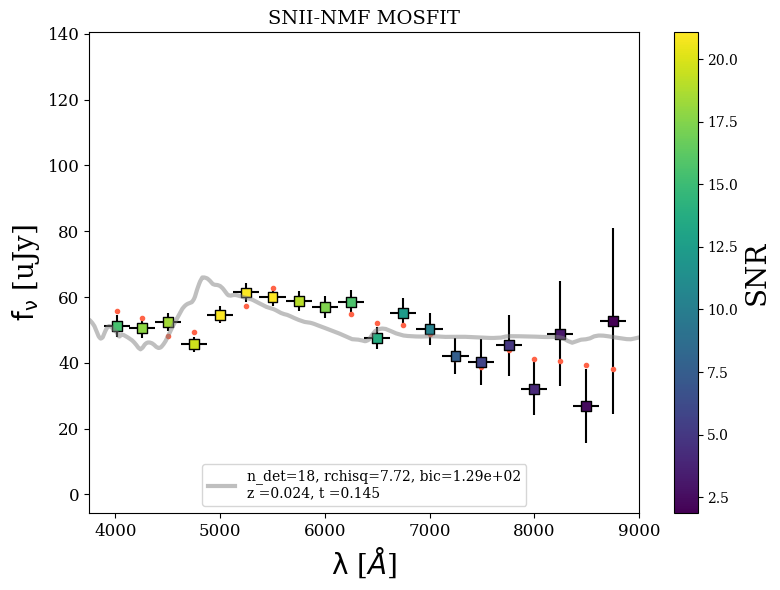

In [37]:
plt.close('all')
plt.figure(figsize=(8, 6))
#	Fitted spectrum
plt.plot(lamarr, fnuarr, c='grey', lw=3, alpha=0.5, label=label)
yl, yu = plt.ylim()
#	Input data
plt.scatter(intbl['lam'], intbl['fnuobs'], c=intbl['snr'], marker='s', s=50, ec='k')
if 'med' in group:
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidth/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)
elif 'broad' in group:
	plt.errorbar(intbl['lam'], intbl['fnuobs'], xerr=bandwidtharr_broad/2, yerr=intbl['fnuerr'], c='k', ls='none', zorder=0)

#	Colorbar
cbar = plt.colorbar()
cbar.set_label("SNR")

#	Input data w/o scatter
plt.plot(intbl['lam'], intbl['fnu'], c='tomato', marker='.', ls='none', zorder=0)

#	Plot setting
plt.title(f"{fittype} {source.upper()}")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if 'med' in group:
	xl = 3750
	xr = 9000
else:
	xl = 3000
	xr = 10000
plt.xlim([xl, xr])
plt.ylim([yl, yu])
plt.xlabel(r"$\rm \lambda$ [$\AA$]")
plt.ylabel(r"$\rm f_\nu$ [uJy]")
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig(outpng, dpi=100)

In [40]:
infotbl

model,II_INDEX,pc1,pc2,pc3
str75,float64,float64,float64,float64
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-0.SED.fits,0.0,0.0,0.0,0.0
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-1.SED.fits,1.0,0.0,0.0,0.01
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-2.SED.fits,2.0,0.0,0.0,0.02
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-3.SED.fits,3.0,0.0,0.0,0.03
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-4.SED.fits,4.0,0.0,0.0,0.04
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-5.SED.fits,5.0,0.0,0.0,0.05
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-6.SED.fits,6.0,0.0,0.0,0.06
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-0_PC3-7.SED.fits,7.0,0.0,0.0,0.07
../model/PLAsTiCC/SNII-NMF/SIMSED.SNII-NMF/IINMF_PC1-0_PC2-1_PC3-0.SED.fits,8.0,0.0,0.01,0.0
